In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Here, we are normalizing the pixel values to the range [0, 1]
datagen = ImageDataGenerator(rescale=1.0/255.0)

# Set the batch size for the data generator
batch_size = 32

# Define the directories for the train, validation, and test sets
train_directory = '/kaggle/input/affectnet-pca-train-test/AffectNet_train_test_224/train/train'
validation_directory = '/kaggle/input/affectnet-pca-train-test/AffectNet_train_test_224/train/validation'
test_directory = '/kaggle/input/affectnet-pca-train-test/AffectNet_train_test_224/test'

# Specify the class names explicitly as strings
class_names = ['anger','contempt','disgust','fear','happy','neutral','sad','surprise']

# Create the image generators for the train, validation, and test sets
train_generator = datagen.flow_from_directory(
    train_directory,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names,
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    validation_directory,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names,
    shuffle=True
)

test_generator = datagen.flow_from_directory(
    test_directory,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names,
    shuffle=False
)

Found 31919 images belonging to 8 classes.
Found 5634 images belonging to 8 classes.
Found 4000 images belonging to 8 classes.


# Vision Transformers

In [2]:
!pip install vit_keras

In [3]:
from vit_keras import vit

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
import tensorflow as tf
import tensorflow_addons as tfa
from vit_keras import vit

In [5]:
from vit_keras import vit
from tensorflow.keras.callbacks import ModelCheckpoint
# Define the image size
image_size = 224

# Define the number of classes
num_classes = 8

# Build the Vision Transformer model
vit_model = vit.vit_b32(
    image_size=image_size,
    activation='sigmoid',
    pretrained=True,
    pretrained_top=False,
    include_top=False,
    classes=len(class_names)  # Use len(class_names) for the number of classes
)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(image_size, image_size, 3)),
    vit_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(11, activation=tfa.activations.gelu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
],
    name='vision_transformer'
)

# Compile the model
learning_rate = 1e-4
optimizer = tfa.optimizers.RectifiedAdam(learning_rate=learning_rate)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    metrics=['accuracy']
)


# Define callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=2,
    verbose=1,
    min_delta=1e-4,
    min_lr=1e-6,
    mode='max'
)

earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=1e-4,
    patience=5,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath='./model',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

callbacks = [earlystopping, reduce_lr, checkpointer]

# Train the model
step_size_train = train_generator.n // train_generator.batch_size
step_size_valid = validation_generator.n // validation_generator.batch_size

# Define a callback to save the best model based on validation accuracy
vit_checkpoint = ModelCheckpoint("best_model_vit.h5", monitor="val_accuracy", mode="max", save_best_only=True)


history = model.fit(
    train_generator,
    steps_per_epoch=step_size_train,
    validation_data=validation_generator,
    validation_steps=step_size_valid,
    epochs=30,
    callbacks=callbacks
)

# Load the best saved ViT model based on validation accuracy
#model.load_weights("best_model_vit.h5")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

353253686/353253686 [==============================] - 1s 0us/step


/opt/conda/lib/python3.10/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Epoch 1/30
997/997 [==============================] - ETA: 0s - loss: 1.9383 - accuracy: 0.3339
Epoch 1: val_accuracy improved from -inf to 0.42312, saving model to ./model
997/997 [==============================] - 343s 311ms/step - loss: 1.9383 - accuracy: 0.3339 - val_loss: 1.8124 - val_accuracy: 0.4231 - lr: 1.0000e-04
Epoch 2/30
997/997 [==============================] - ETA: 0s - loss: 1.6981 - accuracy: 0.4693
Epoch 2: val_accuracy improved from 0.42312 to 0.44283, saving model to ./model
997/997 [==============================] - 300s 301ms/step - loss: 1.6981 - accuracy: 0.4693 - val_loss: 1.8051 - val_accuracy: 0.4428 - lr: 1.0000e-04
Epoch 3/30
997/997 [==============================] - ETA: 0s - loss: 1.6117 - accuracy: 0.5269
Epoch 3: val_accuracy improved from 0.44283 to 0.50160, saving model to ./model
997/997 [==============================] - 300s 301ms/step - loss: 1.6117 - accuracy: 0.5269 - val_loss: 1.6467 - val_accuracy: 0.5016 - lr: 1.0000e-04
Epoch 4/30
997/997 

In [6]:
# Save the best model as an .h5 file
model.save("vision_transformer_model.h5")  # Save the model as an .h5 file# Save the best model as an .h5 file

In [7]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels of the test set
true_labels = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

125/125 [==============================] - 14s 88ms/step
Confusion Matrix:
[[241  18  38  32  11  91  49  20]
 [ 33 198  19   4 120 100  13  13]
 [ 79  20 212  27  33  60  47  22]
 [ 19   7  22 272  14  45  39  82]
 [  9  61   7   4 379  17   5  18]
 [ 41  43  15  13  27 291  38  32]
 [ 45  14  25  34  14 102 251  15]
 [ 11   9  11  80  38  74  22 255]]


In [8]:
import numpy as np
from sklearn.metrics import classification_report

# Get the predicted probabilities for the test set
y_pred_probabilities = model.predict(test_generator)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

# Get the true class labels for the test set
y_true_labels = test_generator.classes

# Get the class names
class_names = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))


125/125 [==============================] - 12s 92ms/step
              precision    recall  f1-score   support

       anger       0.50      0.48      0.49       500
    contempt       0.54      0.40      0.46       500
     disgust       0.61      0.42      0.50       500
        fear       0.58      0.54      0.56       500
       happy       0.60      0.76      0.67       500
     neutral       0.37      0.58      0.45       500
         sad       0.54      0.50      0.52       500
    surprise       0.56      0.51      0.53       500

    accuracy                           0.52      4000
   macro avg       0.54      0.52      0.52      4000
weighted avg       0.54      0.52      0.52      4000



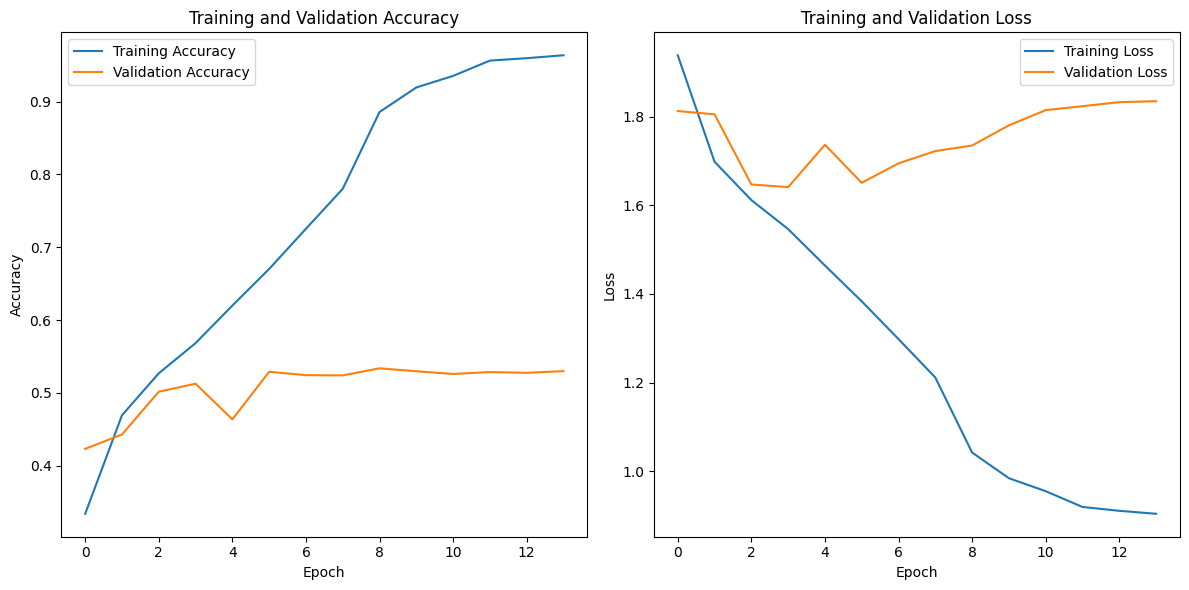

In [10]:
import matplotlib.pyplot as plt

# Access the training history
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create subplots for accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


# ResNet50

In [20]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Lambda, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

num_classes = 8
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224,3))

# Make all layers in the base model non-trainable
for layer in base_model.layers:
    layer.trainable = True

# Repeat the grayscale channel three times
model2 = Sequential()
model2.add(base_model)
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(num_classes, activation='softmax'))  # Replace num_classes with the number of classes in your dataset

# Compile the model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the summary of the model
model2.summary()
# Define a callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint("best_model_resnet50.h5", monitor="val_accuracy", mode="max", save_best_only=True)

# Train the model
epochs = 40
history = model2.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

# Load the best saved model
model2.load_weights("best_model_resnet50.h5")

# Evaluate the model on the test set
test_loss, test_accuracy = model2.evaluate(test_generator, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_32 (Dense)            (None, 128)               12845184  
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_33 (Dense)            (None, 8)                 1032      
                                                                 
Total params: 36,433,928
Trainable params: 36,380,808
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/40
998/998 [================

In [21]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test set
predictions = model2.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels of the test set
true_labels = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

125/125 [==============================] - 9s 62ms/step
Confusion Matrix:
[[280  15  56  21  10  56  34  28]
 [ 57 203  28   4  85  82  29  12]
 [130  25 186  21  20  33  57  28]
 [ 47   4  14 227  15  30  41 122]
 [  8  81  14   4 343  16  10  24]
 [ 98  59  18  18  12 180  65  50]
 [ 88  19  30  19  26  85 203  30]
 [ 26  13  18  80  35  46  31 251]]


In [22]:
import numpy as np
from sklearn.metrics import classification_report

# Get the predicted probabilities for the test set
y_pred_probabilities = model2.predict(test_generator)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

# Get the true class labels for the test set
y_true_labels = test_generator.classes

# Get the class names
class_names = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))


125/125 [==============================] - 7s 58ms/step
              precision    recall  f1-score   support

       anger       0.38      0.56      0.45       500
    contempt       0.48      0.41      0.44       500
     disgust       0.51      0.37      0.43       500
        fear       0.58      0.45      0.51       500
       happy       0.63      0.69      0.66       500
     neutral       0.34      0.36      0.35       500
         sad       0.43      0.41      0.42       500
    surprise       0.46      0.50      0.48       500

    accuracy                           0.47      4000
   macro avg       0.48      0.47      0.47      4000
weighted avg       0.48      0.47      0.47      4000



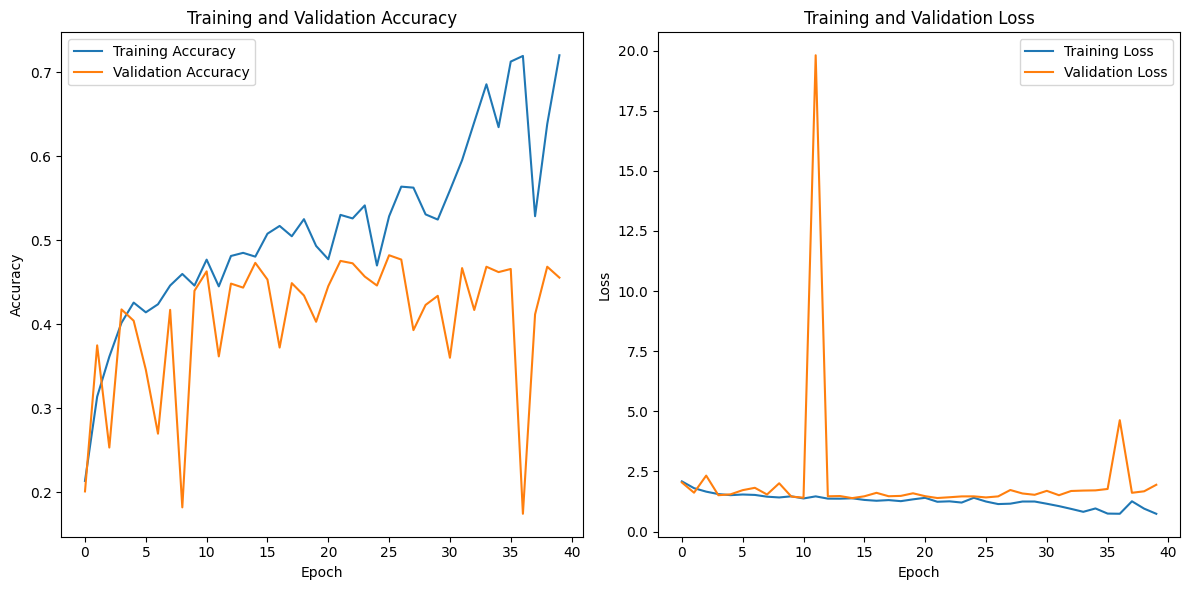

In [23]:
import matplotlib.pyplot as plt

# Access the training history
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create subplots for accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


# DenseNet121

In [24]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the input shape for rgb images
input_shape = (224, 224, 3)

# Define the number of classes in the dataset
num_classes = 8

# Create the DenseNet base model with pre-trained weights (excluding top layers)
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = True

# Lambda layer to repeat the single-channel grayscale image to three channels
input_tensor = Input(shape=input_shape)
x = (input_tensor)

# Connect the modified input tensor to the base model
x = base_model(x)

# Add custom top layers for classification
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(num_classes, activation='softmax')(x)

# Create the custom DenseNet model
densenet_model = Model(inputs=input_tensor, outputs=x)

# Compile the model
densenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
densenet_model.summary()

# Define a callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint("best_model_densenet121.h5", monitor="val_accuracy", mode="max", save_best_only=True)

# Train the model
epochs = 60
history = densenet_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[checkpoint]`
)

# Load the best saved model
densenet_model.load_weights("best_model_densenet121.h5")

# Evaluate the model on the test set
test_loss, test_accuracy = densenet_model.evaluate(test_generator, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

29084464/29084464 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_7   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_34 (Dense)            (None, 512)               524800    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                            

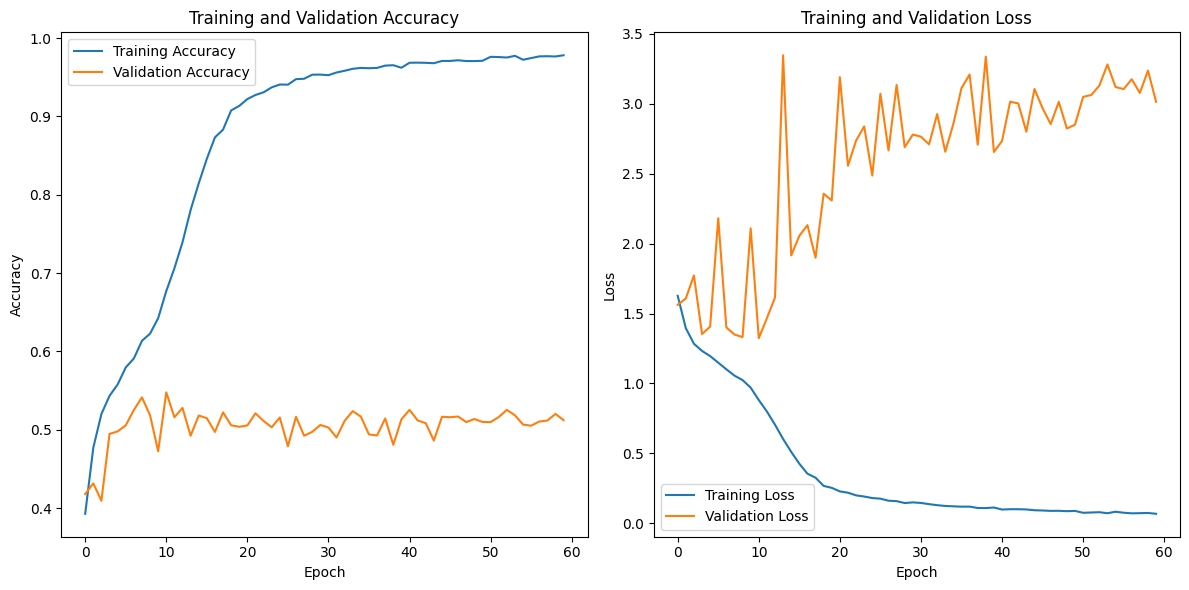

In [25]:
import matplotlib.pyplot as plt

# Access the training history
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create subplots for accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


In [26]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test set
predictions = densenet_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels of the test set
true_labels = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

125/125 [==============================] - 11s 70ms/step
Confusion Matrix:
[[183  27  52  51   4  78  49  56]
 [ 19 218  22   6  82  91  26  36]
 [ 44  19 228  46  27  32  53  51]
 [ 11   6  14 336   7  13  37  76]
 [  2  55   4   5 351  23   6  54]
 [ 16  50  11  28  12 253  61  69]
 [ 26  13  24  47  15  61 286  28]
 [  2  19   9 102  24  33  22 289]]


In [27]:
import numpy as np
from sklearn.metrics import classification_report

# Get the predicted probabilities for the test set
y_pred_probabilities = densenet_model.predict(test_generator)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

# Get the true class labels for the test set
y_true_labels = test_generator.classes

# Get the class names
class_names = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

125/125 [==============================] - 10s 81ms/step
              precision    recall  f1-score   support

       anger       0.60      0.37      0.46       500
    contempt       0.54      0.44      0.48       500
     disgust       0.63      0.46      0.53       500
        fear       0.54      0.67      0.60       500
       happy       0.67      0.70      0.69       500
     neutral       0.43      0.51      0.47       500
         sad       0.53      0.57      0.55       500
    surprise       0.44      0.58      0.50       500

    accuracy                           0.54      4000
   macro avg       0.55      0.54      0.53      4000
weighted avg       0.55      0.54      0.53      4000



In [28]:
import tensorflow as tf
# Create the DenseNet base model with pre-trained weights (excluding top layers)
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(96, 96, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = True

print(len(base_model.layers))

427


In [29]:
print(len(densenet_model.layers))

6


# CNN

In [30]:
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

num_classes = 8

# Build the model
model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

# Define the optimizer and compile the model
optimizer = RMSprop(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Define the checkpoint path to save the best model based on validation accuracy
checkpoint_path = "/kaggle/working/model1_checkpoint.h5"

# Define a ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# Train the model with the defined checkpoint callback
history = model.fit(train_generator, validation_data=validation_generator, epochs=60, callbacks=[checkpoint])

# Load the best model based on validation accuracy
model.load_weights(checkpoint_path)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 dropout_17 (Dropout)        (None, 112, 112, 64)      0         
                                                                 
 conv2d_25 (Conv2D)          (None, 112, 112, 128)   

2023-11-01 13:51:10.616908: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_23/dropout_17/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


998/998 [==============================] - ETA: 0s - loss: 2.2931 - accuracy: 0.1458
Epoch 1: val_accuracy improved from -inf to 0.14821, saving model to /kaggle/working/model1_checkpoint.h5
998/998 [==============================] - 164s 161ms/step - loss: 2.2931 - accuracy: 0.1458 - val_loss: 2.2532 - val_accuracy: 0.1482
Epoch 2/60
998/998 [==============================] - ETA: 0s - loss: 2.0324 - accuracy: 0.2132
Epoch 2: val_accuracy improved from 0.14821 to 0.29801, saving model to /kaggle/working/model1_checkpoint.h5
998/998 [==============================] - 159s 159ms/step - loss: 2.0324 - accuracy: 0.2132 - val_loss: 1.8364 - val_accuracy: 0.2980
Epoch 3/60
998/998 [==============================] - ETA: 0s - loss: 1.7827 - accuracy: 0.3231
Epoch 3: val_accuracy improved from 0.29801 to 0.37451, saving model to /kaggle/working/model1_checkpoint.h5
998/998 [==============================] - 159s 160ms/step - loss: 1.7827 - accuracy: 0.3231 - val_loss: 1.6417 - val_accuracy: 0

In [ ]:
print(len(model.layers))

In [ ]:
import matplotlib.pyplot as plt

# Access the training history
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create subplots for accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels of the test set
true_labels = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Get the predicted probabilities for the test set
y_pred_probabilities = model.predict(test_generator)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

# Get the true class labels for the test set
y_true_labels = test_generator.classes

# Get the class names
class_names = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))


# Vit b16

In [14]:
!pip install vit_keras

In [15]:
from vit_keras import vit

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [16]:
import tensorflow as tf
import tensorflow_addons as tfa
from vit_keras import vit

In [17]:
from vit_keras import vit
from tensorflow.keras.callbacks import ModelCheckpoint
# Define the image size
image_size = 224

# Define the number of classes
num_classes = 7

# Build the Vision Transformer model
vit_model = vit.vit_b16(
    image_size=image_size,
    activation='sigmoid',
    pretrained=True,
    pretrained_top=False,
    include_top=False,
    classes=len(class_names)  # Use len(class_names) for the number of classes
)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(image_size, image_size, 3)),
    vit_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(11, activation=tfa.activations.gelu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
],
    name='vision_transformer'
)

# Compile the model
learning_rate = 1e-4
optimizer = tfa.optimizers.RectifiedAdam(learning_rate=learning_rate)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    metrics=['accuracy']
)


# Define callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=2,
    verbose=1,
    min_delta=1e-4,
    min_lr=1e-6,
    mode='max'
)

earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=1e-4,
    patience=5,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath='./model',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

callbacks = [earlystopping, reduce_lr, checkpointer]

# Train the model
step_size_train = train_generator.n // train_generator.batch_size
step_size_valid = validation_generator.n // validation_generator.batch_size

# Define a callback to save the best model based on validation accuracy
vit_checkpoint = ModelCheckpoint("best_model_vit.h5", monitor="val_accuracy", mode="max", save_best_only=True)


history = model.fit(
    train_generator,
    steps_per_epoch=step_size_train,
    validation_data=validation_generator,
    validation_steps=step_size_valid,
    epochs=30,
    callbacks=callbacks
)

# Load the best saved ViT model based on validation accuracy
#model.load_weights("best_model_vit.h5")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

347502902/347502902 [==============================] - 1s 0us/step


/opt/conda/lib/python3.10/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/30
897/897 [==============================] - ETA: 0s - loss: 1.7899 - accuracy: 0.3870
Epoch 1: val_accuracy improved from -inf to 0.50949, saving model to ./model
897/897 [==============================] - 793s 853ms/step - loss: 1.7899 - accuracy: 0.3870 - val_loss: 1.5986 - val_accuracy: 0.5095 - lr: 1.0000e-04
Epoch 2/30
897/897 [==============================] - ETA: 0s - loss: 1.5393 - accuracy: 0.5438
Epoch 2: val_accuracy improved from 0.50949 to 0.55617, saving model to ./model
897/897 [==============================] - 760s 847ms/step - loss: 1.5393 - accuracy: 0.5438 - val_loss: 1.5154 - val_accuracy: 0.5562 - lr: 1.0000e-04
Epoch 3/30
897/897 [==============================] - ETA: 0s - loss: 1.4285 - accuracy: 0.6113
Epoch 3: val_accuracy improved from 0.55617 to 0.55973, saving model to ./model
897/897 [==============================] - 760s 847ms/step - loss: 1.4285 - accuracy: 0.6113 - val_loss: 1.5124 - val_accuracy: 0.5597 - lr: 1.0000e-04
Epoch 4/30
897/897 

In [18]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels of the test set
true_labels = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

110/110 [==============================] - 30s 249ms/step
Confusion Matrix:
[[265  28  55  47  24  14  67]
 [ 29 428   5  22   2  10   4]
 [ 61  11 306  16  25  30  51]
 [ 52  36  23 275  75  15  24]
 [ 27   9  56  66 290  25  27]
 [ 39  26  50  19  23 254  89]
 [ 59  10  46  23  24  49 289]]


In [19]:
import numpy as np
from sklearn.metrics import classification_report

# Get the predicted probabilities for the test set
y_pred_probabilities = model.predict(test_generator)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

# Get the true class labels for the test set
y_true_labels = test_generator.classes

# Get the class names
class_names = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))


110/110 [==============================] - 27s 248ms/step
              precision    recall  f1-score   support

     neutral       0.50      0.53      0.51       500
       happy       0.78      0.86      0.82       500
         sad       0.57      0.61      0.59       500
    surprise       0.59      0.55      0.57       500
        fear       0.63      0.58      0.60       500
     disgust       0.64      0.51      0.57       500
       anger       0.52      0.58      0.55       500

    accuracy                           0.60      3500
   macro avg       0.60      0.60      0.60      3500
weighted avg       0.60      0.60      0.60      3500



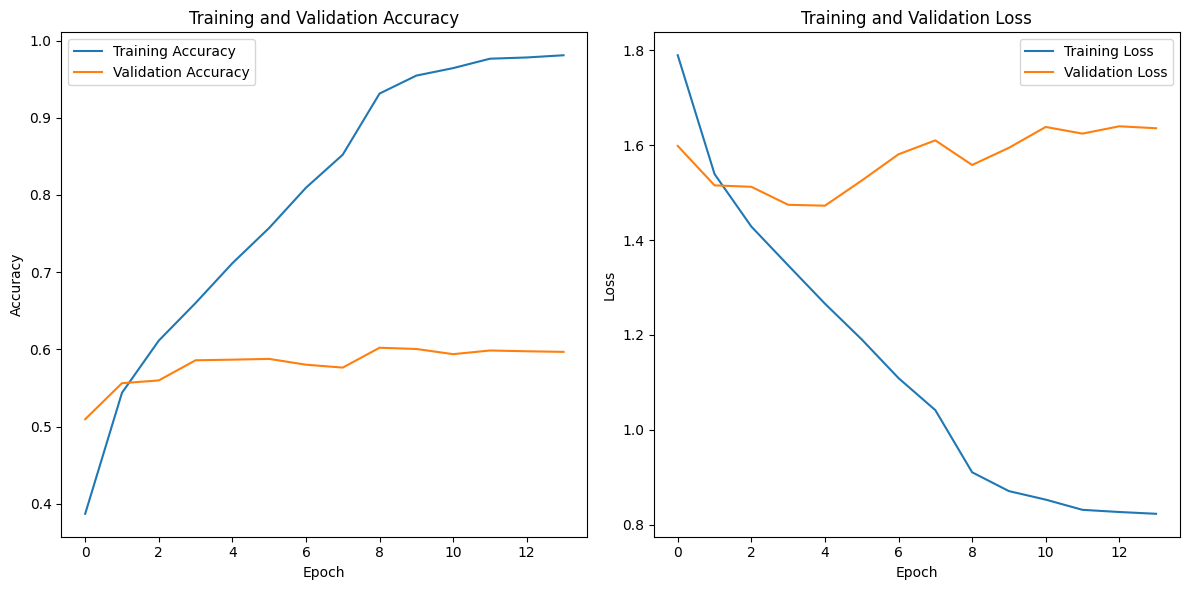

In [20]:
import matplotlib.pyplot as plt

# Access the training history
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create subplots for accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


In [21]:
# Save the best model as an .h5 file
model.save("vitb16.h5")  # Save the model as an .h5 file

In [22]:
print(len(vit_model.layers))

19
